# CNN - Modelling (Multi + AdpGauThresh + Standalone TL)

# 1. Construct MLP 

In [1]:
import tensorflow as tf
%matplotlib inline

CLASS = "Mul"
PRE = "AdpGauThresh"
TECH = "Standalone_TF"

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Fri Sep 17 04:05:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%    

Use MLP on the extracted features to make prediction.

In [3]:
from crack_utils import classification_block
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# define MLP model
def MLP(input_size):
    # define model input
    visible = Input(shape=(input_size, ))
    # add classification block
    layer = classification_block(visible, 32, classes=5)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# 2. Pretrain Model as Standalone Feature Extractor 

Use all layes previous to the output layer.

## 2.1 VGG19


In [4]:
from tensorflow.keras.applications import VGG19

# create model instance
model = VGG19()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-09-17 04:05:16.161 ip-172-31-5-51:13579 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-17 04:05:16.229 ip-172-31-5-51:13579 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [5]:
from crack_utils import load_multi_dataset, extract_in_batch, augment_data
from tensorflow.keras.applications.vgg19 import preprocess_input as pre_vgg19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

SRC_MULTI = "/home/ubuntu/crack/Origin-Multi"

x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (224, 224))

x_train = extract_in_batch(10, x_train, model, "train", pre_vgg19)
x_test = extract_in_batch(10, x_test, model, "test", pre_vgg19)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [6]:
%%time

from crack_utils import multiple_compile

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
histories = dict()

model_name = "{}_{}_TL1_VGG19".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 5.76 s, sys: 673 ms, total: 6.43 s
Wall time: 4.49 s


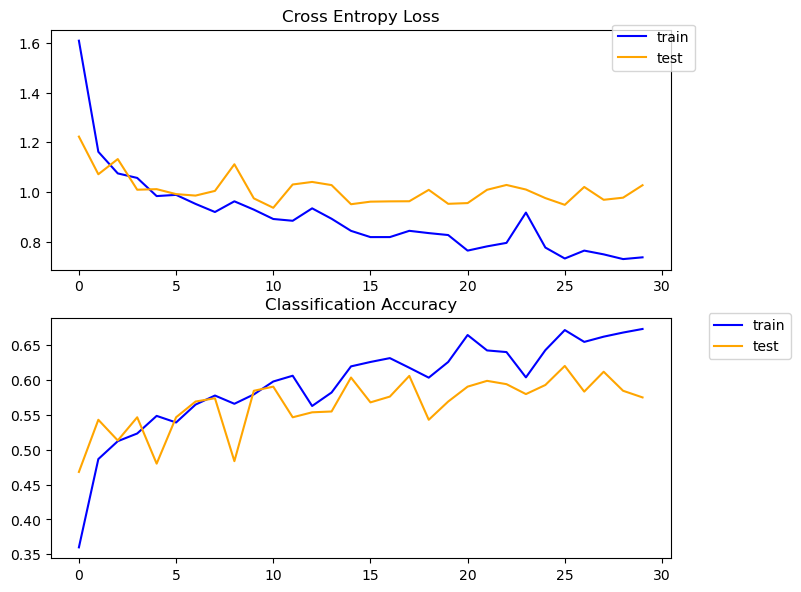

In [7]:
from crack_utils import summarize_diagnostics_multi
                                           
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [8]:
from crack_utils import show_result_multi

results = dict()

results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.03
Test accuracy: 0.57
Test f1 micro: 0.57
Test f1 macro: 0.51
Test f1 weighted: 0.54


## 2.2 ResNet152V2

In [9]:
from tensorflow.keras.applications import ResNet152V2

# create model instance
model = ResNet152V2()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [10]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input as pre_resnet_v2

del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (224, 224))

x_train = extract_in_batch(10, x_train, model, "train", pre_resnet_v2)
x_test = extract_in_batch(10, x_test, model, "test", pre_resnet_v2)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [11]:
%%time

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_ResNet152V2".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 5.06 s, sys: 623 ms, total: 5.68 s
Wall time: 3.77 s


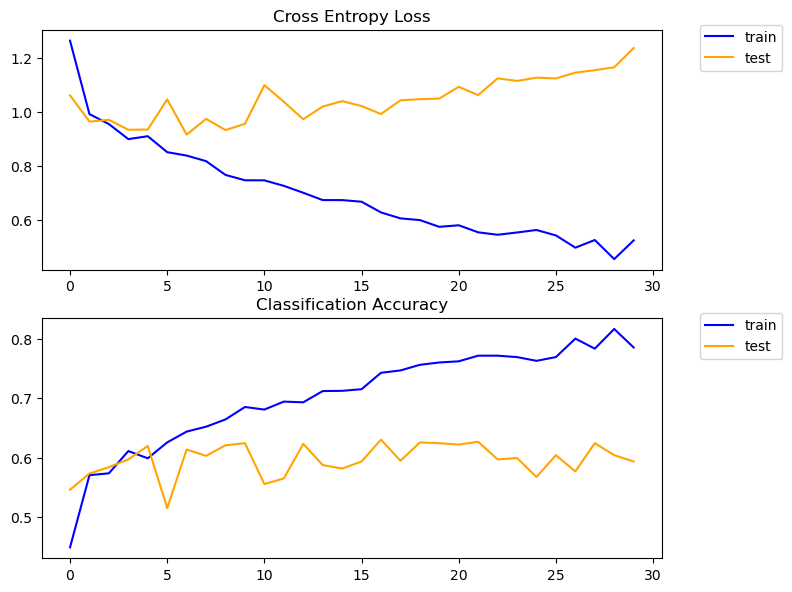

In [12]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [13]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.24
Test accuracy: 0.59
Test f1 micro: 0.59
Test f1 macro: 0.54
Test f1 weighted: 0.56


## 2.3 NASNetLarge

In [14]:
from tensorflow.keras.applications import NASNetLarge

# create model instance
model = NASNetLarge()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 30 batches:

In [15]:
from tensorflow.keras.applications.nasnet import preprocess_input as pre_nasnet

del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (331, 331))

x_train = extract_in_batch(10, x_train, model, "train", pre_nasnet)
x_test = extract_in_batch(10, x_test, model, "test", pre_nasnet)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [16]:
%%time

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_NASNetLarge".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 5.62 s, sys: 673 ms, total: 6.3 s
Wall time: 4.19 s


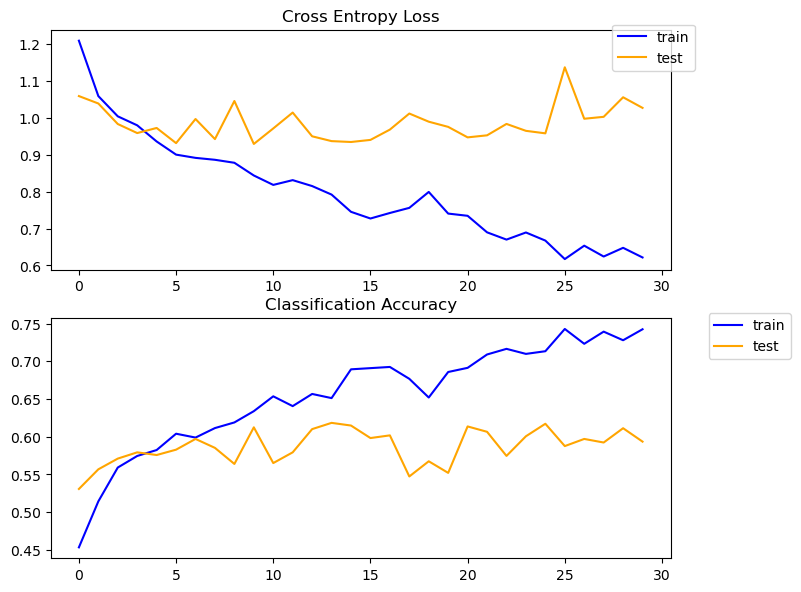

In [17]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [18]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.03
Test accuracy: 0.59
Test f1 micro: 0.59
Test f1 macro: 0.53
Test f1 weighted: 0.57


## 2.4 DenseNet201

In [19]:
from tensorflow.keras.applications import DenseNet201

# create model instance
model = DenseNet201()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [20]:
from tensorflow.keras.applications.densenet import preprocess_input as pre_densenet

del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (224, 224))

x_train = extract_in_batch(10, x_train, model, "train", pre_densenet)
x_test = extract_in_batch(10, x_test, model, "test", pre_densenet)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [21]:
%%time

from crack_utils import binary_compile

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_DenseNet201".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 5.14 s, sys: 595 ms, total: 5.73 s
Wall time: 3.76 s


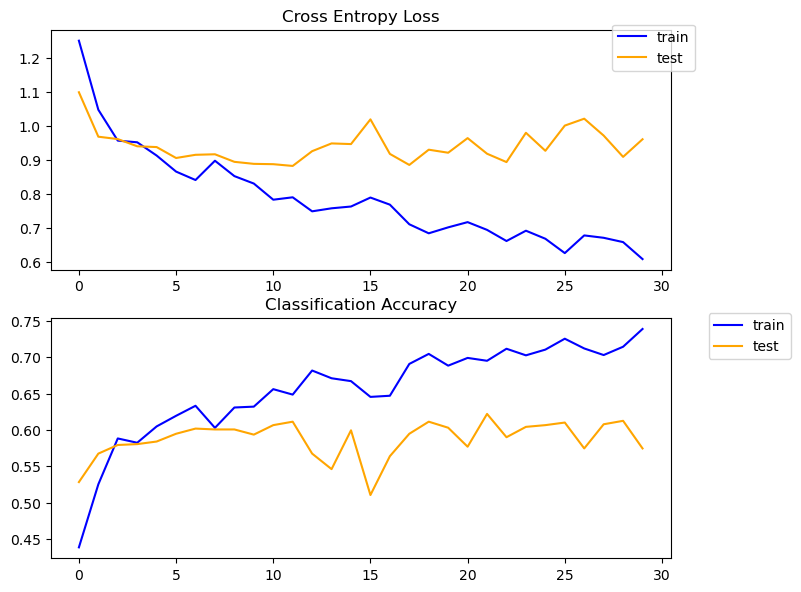

In [22]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [23]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 0.96
Test accuracy: 0.57
Test f1 micro: 0.57
Test f1 macro: 0.59
Test f1 weighted: 0.57


## 2.5 InceptionV3

In [24]:
from tensorflow.keras.applications import InceptionV3

# create model instance
model = InceptionV3()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [25]:
from tensorflow.keras.applications.inception_v3 import preprocess_input as pre_inception_v3

del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (299, 299))

x_train = extract_in_batch(10, x_train, model, "train", pre_inception_v3)
x_test = extract_in_batch(10, x_test, model, "test", pre_inception_v3)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [26]:
%%time

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_InceptionV3".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 5.21 s, sys: 565 ms, total: 5.77 s
Wall time: 3.77 s


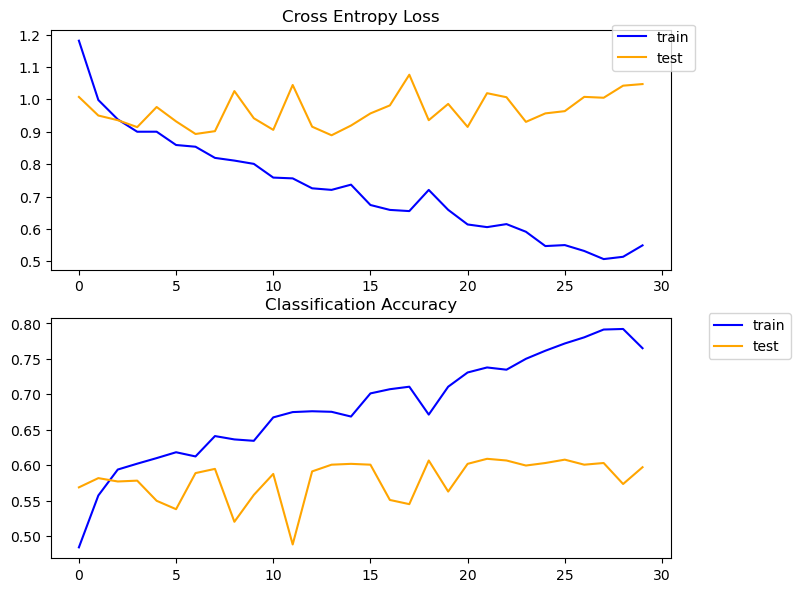

In [27]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [28]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.05
Test accuracy: 0.60
Test f1 micro: 0.60
Test f1 macro: 0.60
Test f1 weighted: 0.60


## 2.6 InceptionResNetV2

In [29]:
from tensorflow.keras.applications import InceptionResNetV2

# create model instance
model = InceptionResNetV2()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [30]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as pre_inception_resnet_v2

del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (299, 299))

x_train = extract_in_batch(10, x_train, model, "train", pre_inception_resnet_v2)
x_test = extract_in_batch(10, x_test, model, "test", pre_inception_resnet_v2)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [31]:
%%time

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_InceptionResNetV2".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 5.03 s, sys: 625 ms, total: 5.65 s
Wall time: 3.7 s


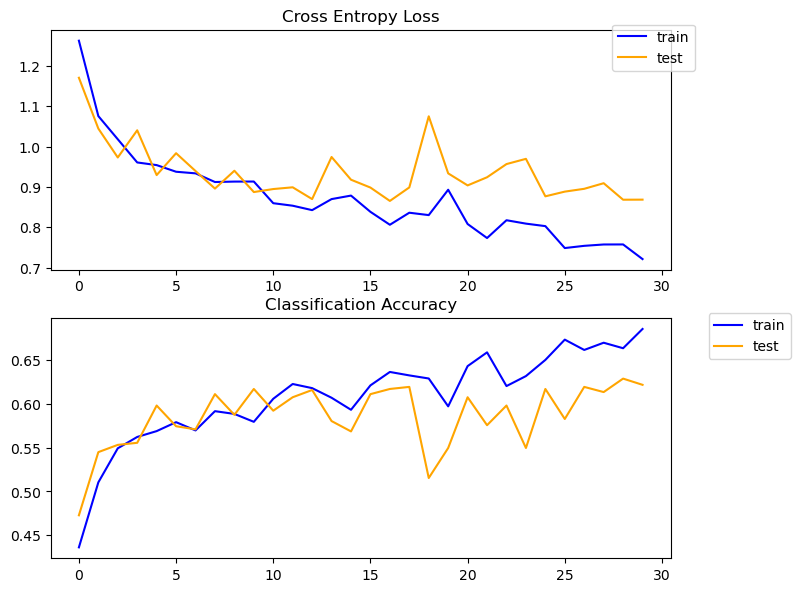

In [32]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [33]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 0.87
Test accuracy: 0.62
Test f1 micro: 0.62
Test f1 macro: 0.58
Test f1 weighted: 0.61


## 2.7 Xception

In [34]:
from tensorflow.keras.applications import Xception

# create model instance
model = Xception()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

Preprocess images and extract features: Due to the insufficient memory issue, we extract the features in 10 batches:

In [35]:
from tensorflow.keras.applications.xception import preprocess_input as pre_xception

del x_train, x_test
x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (299, 299))

x_train = extract_in_batch(10, x_train, model, "train", pre_xception)
x_test = extract_in_batch(10, x_test, model, "test", pre_xception)

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

feature_length = x_train.shape[1]

Fit MLP model:

In [36]:
%%time

# create model instance
model = MLP(feature_length)
multiple_compile(model, 0.01, 0.9)

# fit the model
model_name = "{}_{}_TL1_InceptionXception".format(CLASS, PRE)
histories[model_name] = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_test, y_test), epochs=30, verbose=0).history

CPU times: user 5.22 s, sys: 542 ms, total: 5.76 s
Wall time: 3.76 s


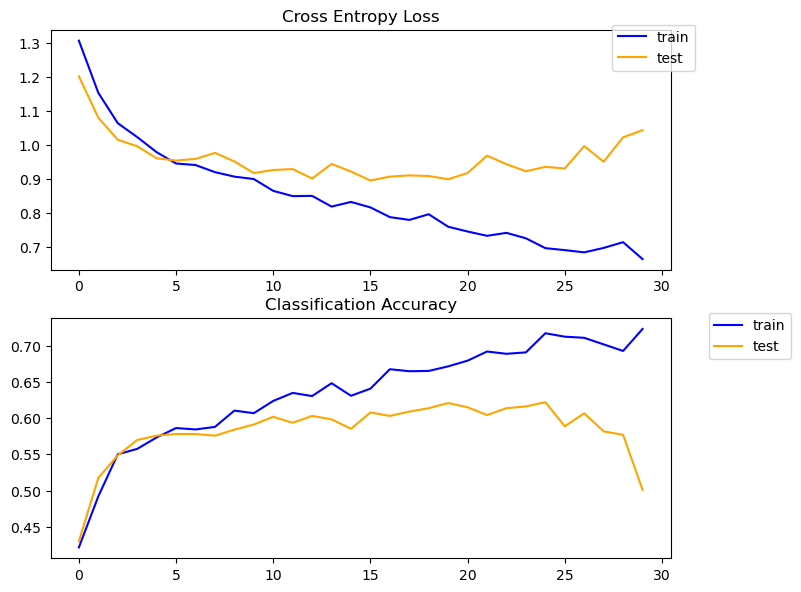

In [37]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [38]:
results[model_name] = show_result_multi(model, x_test, y_test, y_test)

Test loss: 1.04
Test accuracy: 0.50
Test f1 micro: 0.50
Test f1 macro: 0.53
Test f1 weighted: 0.49


# 3. Summary

Final result:

In [39]:
from crack_utils import get_final_result

get_final_result(results).round(2)

,Mul_AdpGauThresh_TL1_VGG19,Mul_AdpGauThresh_TL1_ResNet152V2,Mul_AdpGauThresh_TL1_NASNetLarge,Mul_AdpGauThresh_TL1_DenseNet201,Mul_AdpGauThresh_TL1_InceptionV3,Mul_AdpGauThresh_TL1_InceptionResNetV2,Mul_AdpGauThresh_TL1_InceptionXception
Loss,1.03,1.24,1.03,0.96,1.05,0.87,1.04
Accuracy,0.57,0.59,0.59,0.57,0.60,0.62,0.50
F1 Micro,0.57,0.59,0.59,0.57,0.60,0.62,0.50
F1 Macro,0.51,0.54,0.53,0.59,0.60,0.58,0.53
F1 Weighted,0.54,0.56,0.57,0.57,0.60,0.61,0.49


Compare each model:

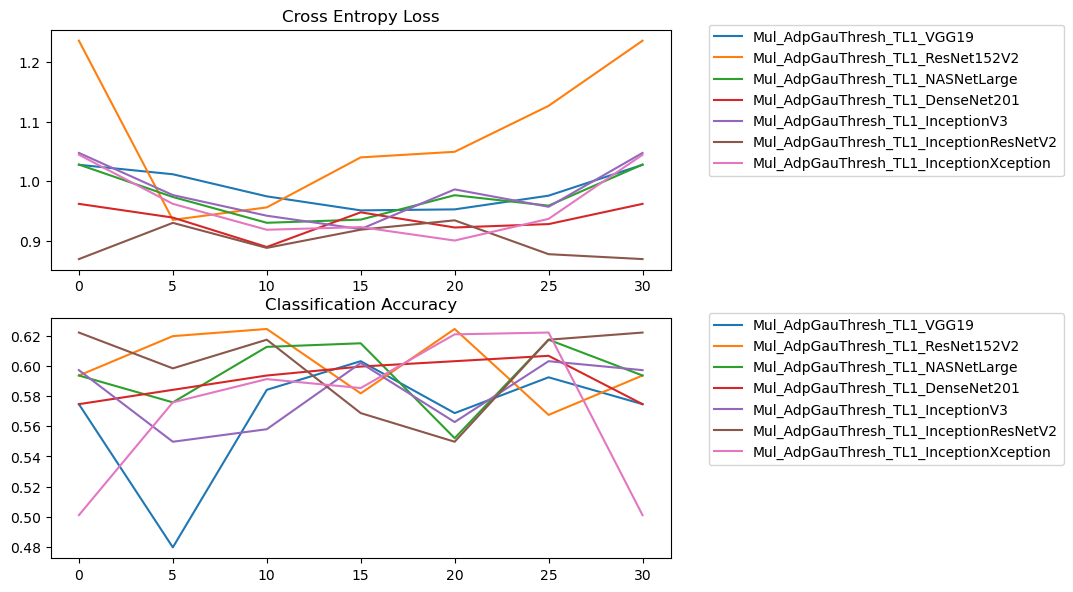

In [40]:
from crack_utils import compare_all_result_multi

compare_all_result_multi(histories, filename="model_plot/Compare_{}_{}_{}.png".format(CLASS, PRE, TECH), end=30, step=5)

Save epochs history:

In [41]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")